In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
import datetime
import pprint

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
'''
1 商品数据分析
'''

In [3]:
AllClass = ['南华商品指数','南华农产品指数','南华金属指数','南华能化指数','南华黄金指数']
CommodityClass = ['南华农产品指数','南华金属指数','南华能化指数','南华黄金指数']

In [4]:
Start_date = '2008-02-29'
End_date = '2019-06-30'

In [5]:
AllData = pd.read_excel('C:/Users/jxjsj/Desktop/FoF与资产配置/资产配置练习用数据/商品与股票.xlsx').dropna().set_index('date')
AllData = AllData[(AllData.index<=End_date) & (AllData.index>=Start_date)].copy()

In [6]:
AllDataM = AllData.copy()
AllDataM['trade_date'] =  AllDataM.index
AllDataM = AllDataM.apply(lambda x: x.resample("M").last()).rename(columns={'trade_date':'date'}).set_index('date')

In [7]:
AllDataReturn = AllData.pct_change().dropna()
AllDataReturnM = AllDataM.pct_change().dropna()

In [ ]:
'''
1.1 相关系数
'''

In [8]:
AllDataReturnM_ = AllDataReturnM.copy()
AllDataReturnM_['中证800月涨跌'] = AllDataReturnM_['中证800']
AllDataReturnM_['上证国债月涨跌'] = AllDataReturnM_['上证国债']
AllDataReturnWithM = AllDataReturn.merge(AllDataReturnM_[['中证800月涨跌','上证国债月涨跌']],left_index=True,right_index=True,how='left').fillna(method='bfill')

In [9]:
# 商品指数之间相关系数
AllDataReturn.corr()

,南华商品指数,南华农产品指数,南华金属指数,南华能化指数,南华黄金指数,中证800,上证国债
南华商品指数,1.000000,0.763916,0.904025,0.910737,0.316744,0.364492,-0.098158
南华农产品指数,0.763916,1.000000,0.538501,0.603653,0.230064,0.279784,-0.080145
南华金属指数,0.904025,0.538501,1.000000,0.777200,0.260130,0.347825,-0.114424
南华能化指数,0.910737,0.603653,0.777200,1.000000,0.261203,0.326259,-0.078382
南华黄金指数,0.316744,0.230064,0.260130,0.261203,1.000000,0.071296,0.018698
中证800,0.364492,0.279784,0.347825,0.326259,0.071296,1.000000,-0.064606
上证国债,-0.098158,-0.080145,-0.114424,-0.078382,0.018698,-0.064606,1.000000


In [10]:
# 条件为股票月度涨跌幅度
CCorrStock = pd.DataFrame()
for xi in [0,0.01,0.02,0.03,0.05,0.07,0.1]:
    xi_up = xi
    AllDataReturnWithM_ = AllDataReturnWithM.copy()
    AllDataReturnWithMSub = AllDataReturnWithM_[AllDataReturnWithM_['中证800月涨跌']>xi_up]
    colCorr = AllDataReturnWithMSub.corr()
    colCorrTmp = colCorr['中证800'].to_frame('中证800 > '+str(xi_up)).T[CommodityClass]
    CCorrStock = pd.concat([CCorrStock,colCorrTmp],axis=0)
for xi in [0,0.01,0.02,0.03,0.05,0.07,0.1]:    
    xi_down = -xi
    AllDataReturnWithM_ = AllDataReturnWithM.copy()
    AllDataReturnWithMSub = AllDataReturnWithM_[AllDataReturnWithM_['中证800月涨跌']<xi_down]
    colCorr = AllDataReturnWithMSub.corr()
    colCorrTmp = colCorr['中证800'].to_frame('中证800 < '+str(xi_down)).T[CommodityClass]
    CCorrStock = pd.concat([CCorrStock,colCorrTmp],axis=0)
    
# 条件为债券月度涨跌幅度
CCorrBond = pd.DataFrame()
for xi in [0,0.001,0.002,0.003,0.005,0.007,0.01,0.016]:
    xi_up = xi
    AllDataReturnWithM_ = AllDataReturnWithM.copy()
    AllDataReturnWithMSub = AllDataReturnWithM_[AllDataReturnWithM_['上证国债月涨跌']>xi_up]
    colCorr = AllDataReturnWithMSub.corr()
    colCorrTmp = colCorr['上证国债'].to_frame('上证国债 > '+str(xi_up)).T[CommodityClass]
    CCorrBond = pd.concat([CCorrBond,colCorrTmp],axis=0)
for xi in [0,0.001,0.002,0.003,0.004,0.005]:
    xi_down = -xi
    AllDataReturnWithM_ = AllDataReturnWithM.copy()
    AllDataReturnWithMSub = AllDataReturnWithM_[AllDataReturnWithM_['上证国债月涨跌']<xi_down]
    colCorr = AllDataReturnWithMSub.corr()
    colCorrTmp = colCorr['上证国债'].to_frame('上证国债 < '+str(xi_down)).T[CommodityClass]
    CCorrBond = pd.concat([CCorrBond,colCorrTmp],axis=0)

In [11]:
CCorrStock

,南华农产品指数,南华金属指数,南华能化指数,南华黄金指数
中证800 > 0,0.247111,0.333498,0.307163,0.109148
中证800 > 0.01,0.270163,0.348972,0.313982,0.118200
中证800 > 0.02,0.317009,0.364262,0.338003,0.116105
中证800 > 0.03,0.338142,0.395969,0.378301,0.116763
中证800 > 0.05,0.343436,0.414697,0.384339,0.128630
中证800 > 0.07,0.366844,0.456724,0.414149,0.188414
中证800 > 0.1,0.337252,0.440418,0.382578,0.154352
中证800 < 0,0.305970,0.351209,0.332888,0.033943
中证800 < -0.01,0.318928,0.374405,0.346458,0.029903
中证800 < -0.02,0.326892,0.375096,0.342767,0.028879


In [12]:
CCorrBond

,南华农产品指数,南华金属指数,南华能化指数,南华黄金指数
上证国债 > 0,-0.075255,-0.120319,-0.077025,0.019101
上证国债 > 0.001,-0.081176,-0.136049,-0.087757,0.010260
上证国债 > 0.002,-0.090765,-0.139625,-0.097353,-0.002482
上证国债 > 0.003,-0.105257,-0.154879,-0.106080,-0.015977
上证国债 > 0.005,-0.152865,-0.209106,-0.187937,0.076418
上证国债 > 0.007,-0.262973,-0.272930,-0.256228,0.121787
上证国债 > 0.01,-0.292636,-0.212819,-0.220612,0.230668
上证国债 > 0.016,-0.324550,-0.266256,-0.246297,0.274695
上证国债 < 0,-0.113753,-0.042448,-0.036439,0.010087
上证国债 < -0.001,-0.163782,-0.131572,-0.093578,-0.017253


In [ ]:
'''
1.2 不同配置方式净值比较
'''

In [13]:
StrategyDateList = AllDataReturnM.index.tolist()

In [62]:
# 简略策略，输入收益率序列矩阵，输出策略净值序列
AllDataStrategyEquity = pd.DataFrame()
for index in AllClass:
    AllDataStrategyEquityIndex = pd.DataFrame()
    index = index
    tol_equity = 1
    for StrategyDateCnt in range(len(StrategyDateList)-1):
        StrategyDate = StrategyDateList[StrategyDateCnt]
        NextStrategyDate = StrategyDateList[StrategyDateCnt+1]
        AllDataReturnSub = AllDataReturn[(AllDataReturn.index>=StrategyDate) & (AllDataReturn.index<=NextStrategyDate)].copy()
        AllDataReturnSub = AllDataReturnSub+1
        AllDataReturnSub = AllDataReturnSub[[index,'中证800','上证国债']].copy()
        # 商品 股票 债券
        AllDataReturnSub.iloc[0,:] = [i*tol_equity for i in [0.2,0.6,0.2]]
        AllDataReturnSubEquity = AllDataReturnSub.cumprod().sum(axis=1).to_frame(index)
        if StrategyDateCnt != 0:
            AllDataReturnSubEquity = AllDataReturnSubEquity.iloc[1:,:]
        tol_equity = AllDataReturnSubEquity.iloc[-1,0]
        AllDataStrategyEquityIndex = pd.concat([AllDataStrategyEquityIndex,AllDataReturnSubEquity],axis=0)
    AllDataStrategyEquity = pd.concat([AllDataStrategyEquity,AllDataStrategyEquityIndex],axis=1)

In [64]:
AllDataStrategyEquityIndex = pd.DataFrame()
index = '经典股债策略'
tol_equity = 1
for StrategyDateCnt in range(len(StrategyDateList)-1):
    StrategyDate = StrategyDateList[StrategyDateCnt]
    NextStrategyDate = StrategyDateList[StrategyDateCnt+1]
    AllDataReturnSub = AllDataReturn[(AllDataReturn.index>=StrategyDate) & (AllDataReturn.index<=NextStrategyDate)].copy()
    AllDataReturnSub = AllDataReturnSub+1
    AllDataReturnSub = AllDataReturnSub[['中证800','上证国债']].copy()
    # 股票 债券
    AllDataReturnSub.iloc[0,:] = [i*tol_equity for i in [0.6,0.4]]
    AllDataReturnSubEquity = AllDataReturnSub.cumprod().sum(axis=1).to_frame(index)
    tol_equity = AllDataReturnSubEquity.iloc[-1,0]
    AllDataStrategyEquityIndex = pd.concat([AllDataStrategyEquityIndex,AllDataReturnSubEquity],axis=0)
AllDataStrategyEquity = pd.concat([AllDataStrategyEquity,AllDataStrategyEquityIndex],axis=1)

In [65]:
# 分析函数 - 计算各类指标
def Indicator(equity_df):
    '''
    输入净值序列，一列，index为日期
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    col_name = df.columns[0]
    df['return'] = df[col_name]/df[col_name].shift(1)-1
    df['drawdown'] = 1-df[col_name]/df[col_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[col_name][-1]/df[col_name][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = df['return'].mean()*252
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 每年收益率
    df_equity = df[[col_name]].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={'equity_series':col_name})

    output_dict = {
                   'mean_return':[mean_return],
                   'vol_return':[vol_return],
                   'IR':[IR],
                   'max_drawdown':[max_drawdown],
                   'mean_return_max_drawdown_ratio':[mean_return_max_drawdown_ratio],
                  }
    output_df = pd.DataFrame(output_dict,index=[col_name]).T
    return output_df, df_return_per_year

In [66]:
IndicatorDfAll = pd.DataFrame()
YearReturnAll = pd.DataFrame()
for index in AllDataStrategyEquity.columns:
    IndicatorDf, YearReturn = Indicator(AllDataStrategyEquity[[index]])
    YearReturnAll = pd.concat([YearReturnAll,YearReturn],axis=1)
    IndicatorDfAll = pd.concat([IndicatorDfAll,IndicatorDf],axis=1)

In [67]:
IndicatorDfAll.T

,mean_return,vol_return,IR,max_drawdown,mean_return_max_drawdown_ratio
南华商品指数,0.036380,0.172195,0.211270,0.448973,0.081029
南华农产品指数,0.031415,0.167103,0.187997,0.434175,0.072355
南华金属指数,0.039790,0.176873,0.224964,0.470557,0.084560
南华能化指数,0.036565,0.175980,0.207778,0.450377,0.081187
南华黄金指数,0.039829,0.164825,0.241643,0.430106,0.092602
经典股债策略,0.040491,0.158710,0.255122,0.399297,0.101404


In [68]:
YearReturnAll

,南华商品指数,南华农产品指数,南华金属指数,南华能化指数,南华黄金指数,经典股债策略
date,,,,,,
2008-12-31,-0.387470,-0.366007,-0.421425,-0.379597,-0.342387,-0.319378
2009-12-31,0.719381,0.645796,0.824026,0.739313,0.653898,0.570658
2010-12-31,-0.009940,0.004922,-0.039970,-0.017089,0.013920,-0.024505
2011-12-31,-0.194544,-0.189359,-0.194668,-0.204323,-0.157983,-0.157314
2012-12-31,0.056829,0.049402,0.046326,0.075399,0.061798,0.055801
2013-12-31,-0.028068,-0.009008,-0.022808,-0.040911,-0.069849,0.004331
2014-12-31,0.241109,0.259781,0.249672,0.216729,0.287204,0.296231
2015-12-31,0.080175,0.104051,0.062005,0.073538,0.097660,0.128812
2016-12-31,0.019057,-0.028540,0.033184,0.049815,-0.030648,-0.058855


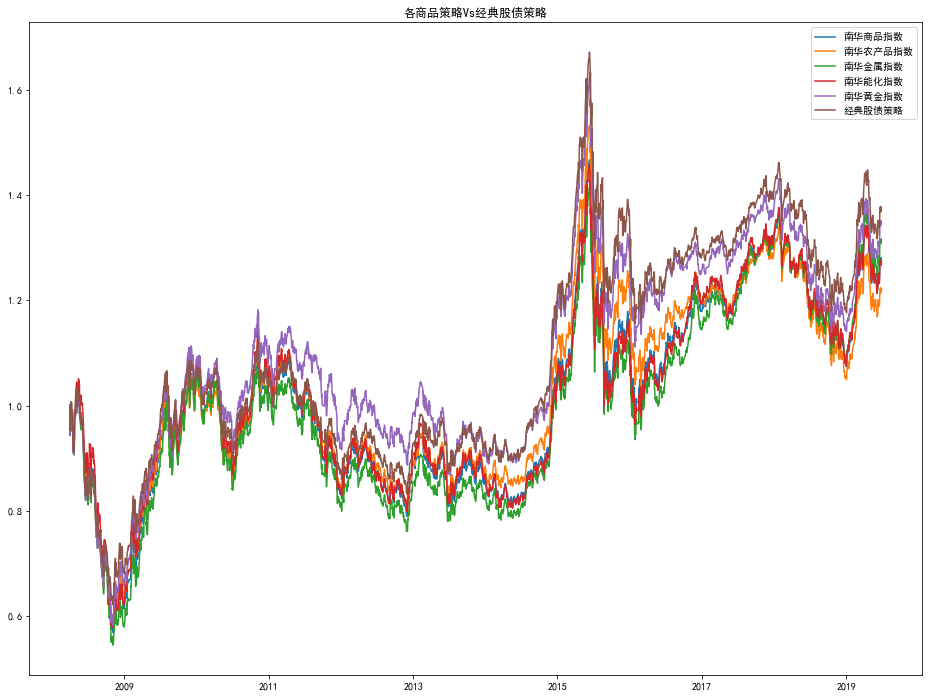

In [69]:
plt.figure(figsize=(16,12))
plt.title('各商品策略Vs经典股债策略')
for index in AllDataStrategyEquity.columns:
    plt.plot(AllDataStrategyEquity[index],label=index)
plt.legend(loc=0)

In [ ]:
'''
1.3 不同配置相对于经典股债策略的收益变化 - 基于1.2，没有内部挑选的股债商品策略还不如经典股债，要进一步分析

原始数据要用各类策略与经典策略+股票指数月涨跌幅数据框！ -> 波动巨大，有很多值分母极小！！
'''

In [74]:
# 策略净值数据 -> 净值转变为收益率 -> 匹配股票月度涨跌幅数据 
AllDataStrategyEquity_ = AllDataStrategyEquity.copy()
AllDataStrategyEquity_['trade_date'] = AllDataStrategyEquity_.index
StrategyVsClassicReturn = AllDataStrategyEquity_.apply(lambda x: x.resample("M").last()).rename(columns={'trade_date':'date'}).set_index('date').pct_change().dropna().merge(AllDataReturnM_[['中证800月涨跌','上证国债月涨跌']],left_index=True,right_index=True)

In [144]:
def ComputeLCostVsLReturn(df):
    df = df.copy()
    save_df = pd.DataFrame()
    for date in df.index:
        dfSub = df[df.index<=date].copy()
        if len(dfSub)<60:
            continue
        else:
            dfSub = dfSub.iloc[-60:,:]
            quntile_small = dfSub['中证800月涨跌'].quantile(0.01)
#             quntile_big = dfSub['中证800月涨跌'].quantile(0.9)
            quntile_big = 0
            
            dfSubBigLose = dfSub[dfSub['中证800月涨跌']<=quntile_small].copy()
            dfSubBigWin = dfSub[dfSub['中证800月涨跌']>quntile_big].copy()
            
            for Class in AllClass:
                # 股票大跌时的损失减少
                dfSubBigLose[Class] = dfSubBigLose.apply(lambda x: x[Class]-x['经典股债策略'],axis=1)
                # 股票大涨时的收益减少
                dfSubBigWin[Class] = dfSubBigWin.apply(lambda x: x['经典股债策略']-x[Class],axis=1)
            
            dfSubBigLose_ = dfSubBigLose + 1
            dfSubBigLose_ = (dfSubBigLose_.prod()-1)
            
            dfSubBigWin_ = dfSubBigWin + 1
            dfSubBigWin_ = (dfSubBigWin_.prod()-1)

#             dfSubBigLose_ = dfSubBigLose.sum()
#             dfSubBigWin_ = dfSubBigWin.sum()
        
            result = (dfSubBigLose_/dfSubBigWin_.to_frame(date).T)[AllClass]
            
            save_df = pd.concat([save_df,result],axis=0)
            
    return save_df

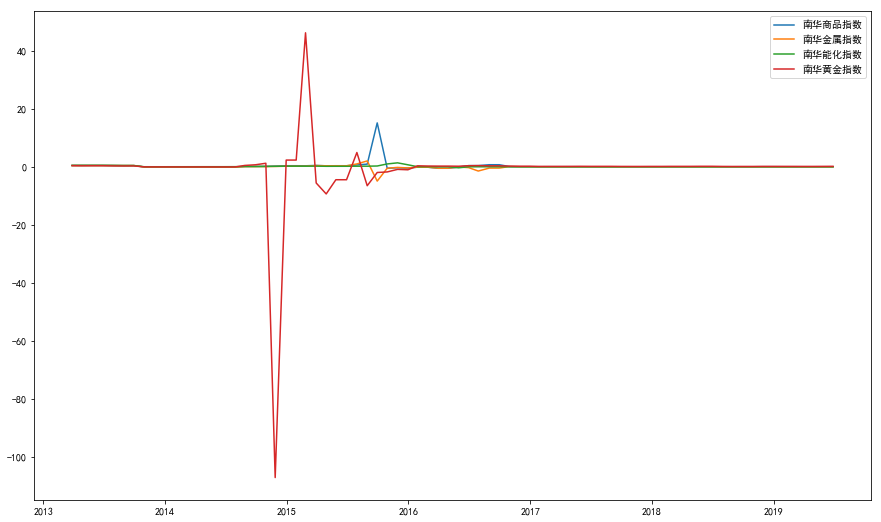

In [145]:
ComputeLCostVsLReturnDf = ComputeLCostVsLReturn(StrategyVsClassicReturn)
plt.figure(figsize=(15,9))
for col in ['南华商品指数','南华金属指数','南华能化指数','南华黄金指数']:
    plt.plot(ComputeLCostVsLReturnDf[col],label=col)
plt.legend(loc=0)
plt.show()